In [1]:
# =============================
# Importing Libraries
# =============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats

In [2]:
df = pd.read_csv('Intellimark Assessment_ Associate-DS_ Demand Forecasting Problem.csv')
df.head()

,weekend_date,channel,brand,category,sub_category,SerailNum,quantity
0,4/6/2022,Channel1,B1,Cat2,Sub-Cat2,1,56
1,11/6/2022,Channel1,B1,Cat2,Sub-Cat2,1,122
2,18/06/2022,Channel1,B1,Cat2,Sub-Cat2,1,102
3,25/06/2022,Channel1,B1,Cat2,Sub-Cat2,1,128
4,2/7/2022,Channel1,B1,Cat2,Sub-Cat2,1,97


In [3]:
df.shape

(600, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   weekend_date  600 non-null    object
 1   channel       600 non-null    object
 2   brand         600 non-null    object
 3   category      600 non-null    object
 4   sub_category  600 non-null    object
 5   SerailNum     600 non-null    int64 
 6   quantity      600 non-null    int64 
dtypes: int64(2), object(5)
memory usage: 32.9+ KB


In [5]:
df.describe()

,SerailNum,quantity
count,600.000000,600.000000
mean,3.048333,547.330000
std,1.399737,925.749108
min,1.000000,1.000000
25%,2.000000,121.000000
50%,3.000000,244.500000
75%,4.000000,624.500000
max,5.000000,8051.000000


In [6]:
print("Columns in df:", df.columns.tolist())

Columns in df: ['weekend_date', 'channel', 'brand', 'category', 'sub_category', 'SerailNum', 'quantity']


In [7]:
#Check Unique Values
for col in df:
    print(f"{col}: {df[col].nunique()} unique values")

weekend_date: 225 unique values
channel: 3 unique values
brand: 2 unique values
category: 3 unique values
sub_category: 4 unique values
SerailNum: 5 unique values
quantity: 426 unique values


In [8]:
# ===============================
# 1. DATA PREPROCESSING
# ===============================
print("\n--- Missing Values Check ---")
print(df.isnull().sum())

# Fill missing dates (if date column exists)
if 'Week' in df.columns:
    df['Week'] = pd.to_datetime(df['Week'])
    df = df.sort_values('Week')
    df = df.set_index('Week').asfreq('W').reset_index()

# Fill missing numerical values with median
for col in df.select_dtypes(include=[np.number]).columns:
    df[col] = df[col].fillna(df[col].median())


--- Missing Values Check ---
weekend_date    0
channel         0
brand           0
category        0
sub_category    0
SerailNum       0
quantity        0
dtype: int64


In [9]:
# ===============================
# 2. OUTLIER DETECTION
# ===============================
print("\n--- Outlier Detection ---")
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    z_scores = np.abs(stats.zscore(df[col]))
    outliers = df[z_scores > 3]
    if not outliers.empty:
        print(f"Outliers detected in {col}: {len(outliers)} rows")

# Handling: Cap extreme values at 1st & 99th percentile
for col in numeric_cols:
    lower, upper = df[col].quantile([0.01, 0.99])
    df[col] = np.clip(df[col], lower, upper)


--- Outlier Detection ---
Outliers detected in quantity: 15 rows



--- Exploratory Data Analysis ---


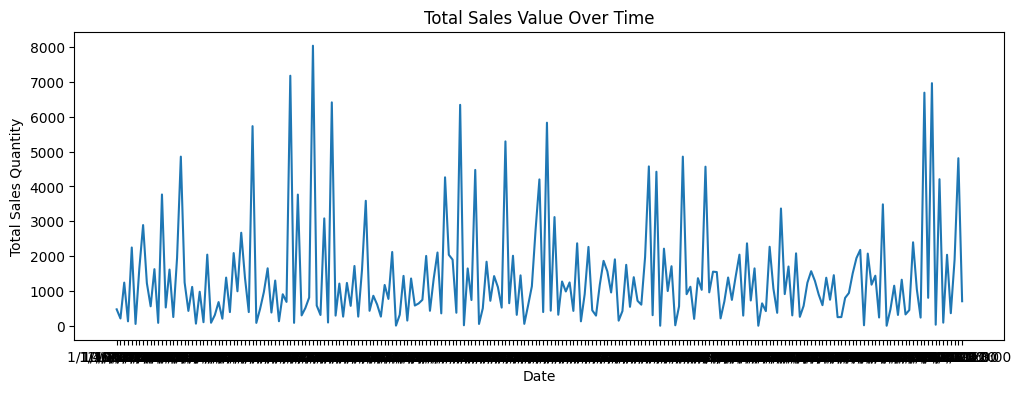

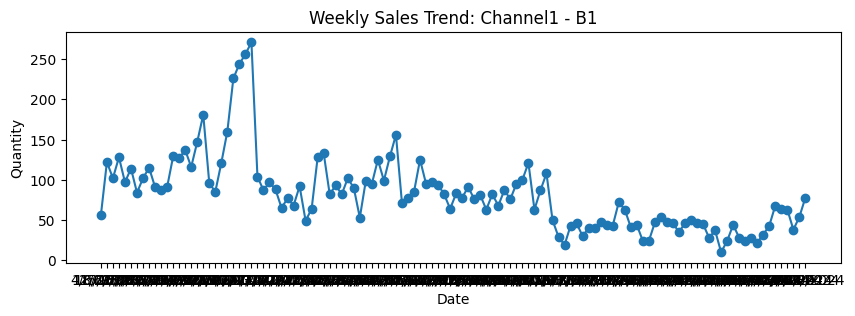

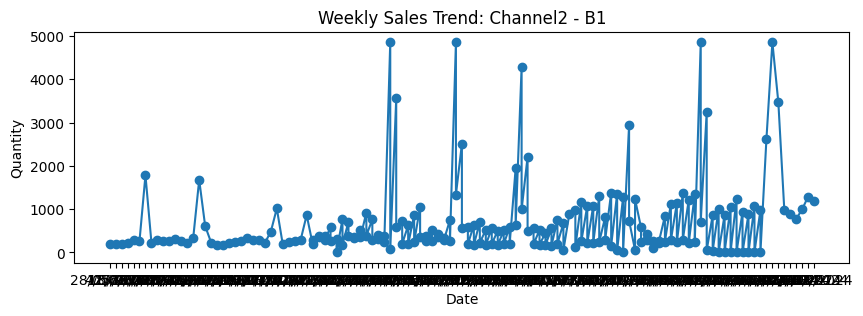

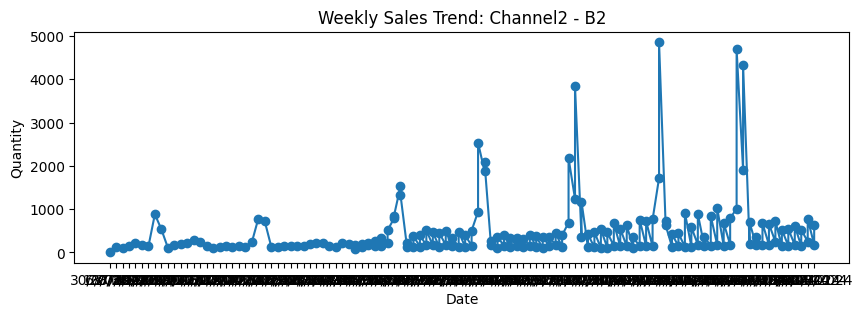

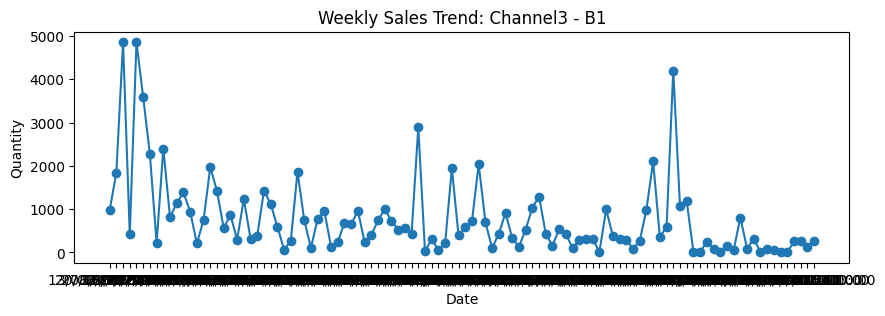

In [10]:
## ===============================
# 3. EXPLORATORY DATA ANALYSIS
# ===============================
print("\n--- Exploratory Data Analysis ---")

# Weekly total trend
total_sales = df.groupby('weekend_date')['quantity'].sum()
plt.figure(figsize=(12,4))
plt.plot(total_sales.index, total_sales.values)
plt.title('Total Sales Value Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales Quantity')
plt.show()

# Per channel-brand trend
for (channel, brand), group in df.groupby(['channel','brand']):
    plt.figure(figsize=(10,3))
    plt.plot(group['weekend_date'], group['quantity'], marker='o')
    plt.title(f"Weekly Sales Trend: {channel} - {brand}")
    plt.xlabel("Date"); plt.ylabel("Quantity")
    plt.show()


In [11]:
# ===============================
# 4. NON-FORECASTABLE SERIES
# ===============================
print("\n--- Non-Forecastable Series ---")
# Coefficient of variation and basic trend
for (channel, brand), group in df.groupby(['channel','brand']):
    vals = group.sort_values('weekend_date')['quantity']
    cv = np.std(vals) / (np.mean(vals)+1e-6)
    print(f"{channel} - {brand}: Coefficient of Variation: {cv:.2f}")
    if cv > 1.5:
        print(f"Likely non-forecastable (too random/high variance)")



--- Non-Forecastable Series ---
Channel1 - B1: Coefficient of Variation: 0.57
Channel2 - B1: Coefficient of Variation: 1.28
Channel2 - B2: Coefficient of Variation: 1.47
Channel3 - B1: Coefficient of Variation: 1.21


In [12]:
# ===============================
# 5. FORECASTING MODEL
# ===============================
print("\n--- Forecasting Model ---")
# Filter and sort
filt = (df['channel'] == 'Channel1') & (df['brand'] == 'B1')
df1 = df[filt].sort_values('weekend_date').reset_index(drop=True)

# Create lag features
for i in range(1, 5):
    df1[f'lag_{i}'] = df1['quantity'].shift(i)
df1 = df1.dropna()

# Features/target
feature_cols = [f'lag_{i}' for i in range(1, 5)]
X = df1[feature_cols]
y = df1['quantity']

# Fit model
model = LinearRegression()
model.fit(X, y)

# Predict next 8 weeks using last known lags
last_row = df1.iloc[-1]
lags = list(last_row[feature_cols].values)
future_preds = []
for _ in range(8):
    X_next = pd.DataFrame([lags], columns=feature_cols)
    pred = model.predict(X_next)
    future_preds.append(pred)
    lags = [pred] + lags[:-1]

print("Predicted sales for next 8 weeks:", future_preds)

# Evaluate
y_pred = model.predict(X)  # X retains correct names
rmse = mean_squared_error(y, y_pred, squared=False)
mae = mean_absolute_error(y, y_pred)
print(f"Model RMSE: {rmse:.2f}, MAE: {mae:.2f}")


--- Forecasting Model ---
Predicted sales for next 8 weeks: [array([87.48473529]), array([77.37489218]), array([83.12550639]), array([78.6948235]), array([81.93915285]), array([83.32723231]), array([81.59996069]), array([81.89096715])]
Model RMSE: 43.21, MAE: 31.79


Non-parsable dates: 406


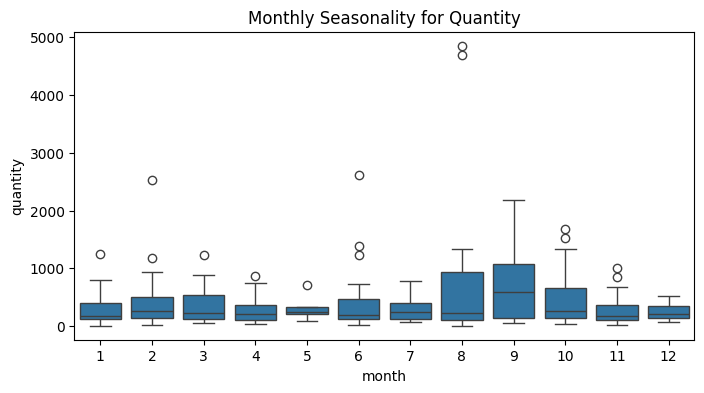

In [14]:
# ===============================
# BONUS: Feature Engineering
# ===============================
# Ensure datetime dtype
df['weekend_date'] = pd.to_datetime(df['weekend_date'], errors='coerce')  # add format=... if known

# Optional: check failures
failed = df['weekend_date'].isna().sum()
print(f"Non-parsable dates: {failed}")

# Remove rows that couldn't be parsed (or handle differently)
df = df.dropna(subset=['weekend_date'])

# Extract month and plot
df['month'] = df['weekend_date'].dt.month
plt.figure(figsize=(8, 4))
sns.boxplot(x='month', y='quantity', data=df)
plt.title("Monthly Seasonality for Quantity")
plt.show()


--- ARIMA Model ---
ARIMA RMSE: 822.9545974261479
ARIMA MAE: 483.7888819915819


D:\New folder\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\New folder\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\New folder\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\New folder\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\New folder\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWa

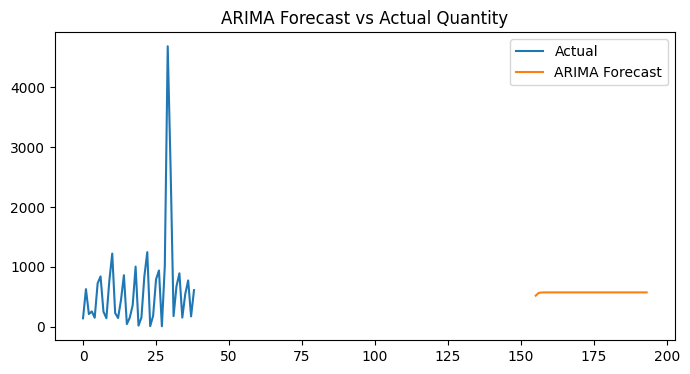

In [68]:
# ===============================
# 6. ARIMA Forecasting (Optional)
# ===============================
import statsmodels.api as sm

print("\n--- ARIMA Model ---")

sales_series = df['quantity']

# Train-Test Split
train_size = int(len(sales_series) * 0.8)
train, test = sales_series[:train_size], sales_series[train_size:]

# Fit ARIMA model
arima_model = sm.tsa.ARIMA(train, order=(1,1,1))
arima_fit = arima_model.fit()

# Forecast
forecast = arima_fit.forecast(steps=len(test))

# Evaluate
arima_rmse = np.sqrt(mean_squared_error(test, forecast))
arima_mae = mean_absolute_error(test, forecast)
print("ARIMA RMSE:", arima_rmse)
print("ARIMA MAE:", arima_mae)

# Plot
plt.figure(figsize=(8,4))
plt.plot(test.values, label="Actual")
plt.plot(forecast, label="ARIMA Forecast")
plt.legend()
plt.title("ARIMA Forecast vs Actual Quantity")
plt.show()


--- ARIMA Model ---
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2075.660, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2058.096, Time=0.00 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2073.665, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2042.604, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1988.187, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1977.196, Time=0.03 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1978.783, Time=0.05 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1978.242, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1976.248, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1995.540, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1978.482, Time=0.08 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1979.136, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0

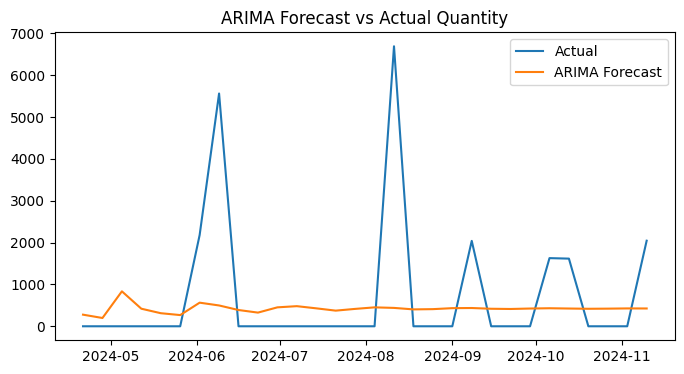


Next 12 weeks forecast: 2024-04-21    277.361047
2024-04-28    197.948051
2024-05-05    834.536976
2024-05-12    419.601386
2024-05-19    312.223122
2024-05-26    267.613326
2024-06-02    563.832879
2024-06-09    497.143070
2024-06-16    388.419808
2024-06-23    326.476785
2024-06-30    452.167273
2024-07-07    480.433044
Freq: W-SUN, dtype: float64


In [98]:
# ===============================
# 6. ARIMA Forecasting (Fixed for duplicate dates)
# ===============================
import statsmodels.api as sm
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("\n--- ARIMA Model ---")

# Ensure weekend_date is datetime and aggregate by week
if "weekend_date" in df.columns:
    df['weekend_date'] = pd.to_datetime(df['weekend_date'], errors='coerce')
    df = df.groupby('weekend_date')['quantity'].sum().reset_index()
    df = df.set_index('weekend_date').sort_index()

# Make weekly frequency series
sales_series = df['quantity'].resample('W').sum()

# Train-Test Split (80-20)
train_size = int(len(sales_series) * 0.8)
train, test = sales_series[:train_size], sales_series[train_size:]

# Auto ARIMA
stepwise_model = auto_arima(train, seasonal=False, trace=True,
                            error_action='ignore', suppress_warnings=True,
                            stepwise=True)

print(stepwise_model.summary())

# Fit final model
arima_fit = stepwise_model.fit(train)

# Forecast
forecast = arima_fit.predict(n_periods=len(test))

# Evaluate
arima_rmse = np.sqrt(mean_squared_error(test, forecast))
arima_mae = mean_absolute_error(test, forecast)
print("ARIMA RMSE:", arima_rmse)
print("ARIMA MAE:", arima_mae)

# Plot
plt.figure(figsize=(8,4))
plt.plot(test.index, test.values, label="Actual")
plt.plot(test.index, forecast, label="ARIMA Forecast")
plt.legend()
plt.title("ARIMA Forecast vs Actual Quantity")
plt.show()

# Optional: Forecast next 12 weeks
future_forecast = arima_fit.predict(n_periods=12)
print("\nNext 12 weeks forecast:", future_forecast)


--- XGBoost Model ---
XGBoost RMSE: 849.3698163259181
XGBoost MAE: 477.5241858536158


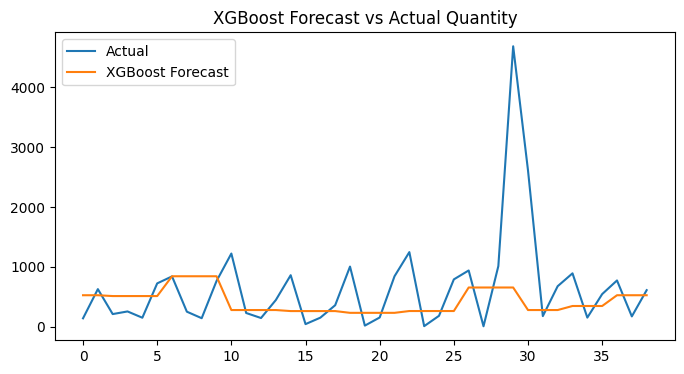

In [72]:
# ===============================
# 7. XGBoost Forecasting (Optional)
# ===============================
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("\n--- XGBoost Model ---")

# Define available features (no media_cols in your dataset)
features = []

if 'Discount' in df.columns:
    features.append('Discount')
if 'month' in df.columns:
    features.append('month')
if 'quarter' in df.columns:
    features.append('quarter')
if 'quantity' in df.columns:
    target_col = 'quantity'   # since you don't have Total_Sales
else:
    raise ValueError("No suitable target column found!")

X = df[features]
y = df[target_col]
# Train-Test Split
train_size = int(len(df) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train XGBoost
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

# Performance
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)

print("XGBoost RMSE:", xgb_rmse)
print("XGBoost MAE:", xgb_mae)

# Plot
plt.figure(figsize=(8,4))
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred_xgb, label="XGBoost Forecast")
plt.legend()
plt.title("XGBoost Forecast vs Actual Quantity")
plt.show()

In [74]:
# ===============================
# 8. Model Comparison Summary
# ===============================
print("\n--- Model Performance Comparison ---")
print(f"Linear Regression → RMSE: {rmse:.2f}, MAE: {mae:.2f}")
print(f"ARIMA             → RMSE: {arima_rmse:.2f}, MAE: {arima_mae:.2f}")
print(f"XGBoost           → RMSE: {xgb_rmse:.2f}, MAE: {xgb_mae:.2f}")


--- Model Performance Comparison ---
Linear Regression → RMSE: 43.21, MAE: 31.79
ARIMA             → RMSE: 822.95, MAE: 483.79
XGBoost           → RMSE: 849.37, MAE: 477.52
